## Get the data

In [2]:
import pandas as pd

df = pd.read_csv("../Data/cleaned_dataset.csv")
df

,Mean Temperature,Mean Pressure,Rainfall,Relative Humidity,Mean Cloud,Evaporation,Global Solar Radiation,Max UV,Wind Speed,Mean UV,...,RSP,O3,FSP,Intensity,Signal,Duration(hr min),day_sin,day_cos,wind_sin,wind_cos
0,15.4,1025.1,0.00,68.0,57.0,3.4,18.11,10.072187,6.730814,4.592663,...,43.0,0.0,31.0,0.0,0.0,0.0,0.999991,0.004304,0.173648,0.984808
1,16.6,1025.8,0.00,69.0,79.0,3.1,12.94,9.279723,8.470005,3.780165,...,57.0,0.0,37.0,0.0,0.0,0.0,0.999917,-0.012910,0.173648,0.984808
2,17.5,1023.0,0.00,69.0,53.0,4.0,20.32,10.851292,6.246643,5.183114,...,51.0,0.0,37.0,0.0,0.0,0.0,0.999546,-0.030120,0.173648,0.984808
3,18.5,1018.7,0.00,78.0,89.0,2.8,12.21,11.371977,10.663324,4.197858,...,53.0,-0.0,33.0,0.0,0.0,0.0,0.998880,-0.047321,0.342020,0.939693
4,19.7,1014.7,0.05,85.0,90.0,1.6,11.50,10.239657,11.126056,3.814848,...,54.0,-0.0,33.0,0.0,0.0,0.0,0.997917,-0.064508,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157,27.3,1009.3,0.05,73.0,77.0,3.1,9.52,4.000000,12.200000,2.000000,...,24.0,65.0,18.0,0.0,0.0,0.0,-0.891981,0.452072,0.984808,-0.173648
12158,25.8,1010.1,0.05,67.0,83.0,3.0,6.97,4.000000,9.700000,2.000000,...,16.0,28.0,11.0,0.0,0.0,0.0,-0.884068,0.467359,0.500000,0.866025
12159,25.3,1011.1,0.05,69.0,86.0,3.0,9.41,6.000000,8.400000,2.000000,...,19.0,31.0,14.0,0.0,0.0,0.0,-0.875892,0.482508,0.500000,0.866025
12160,26.2,1010.3,0.00,64.0,70.0,5.0,18.57,7.000000,8.300000,3.000000,...,28.0,36.0,20.0,0.0,0.0,0.0,-0.867456,0.497513,0.500000,0.866025


In [3]:
from sklearn.model_selection import train_test_split

tem_train, tem_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

In [9]:
print(tem_train[[col for col in tem_train.columns if col != "Mean Temperature"]].columns)

Index(['Mean Pressure', 'Rainfall', 'Relative Humidity', 'Mean Cloud',
       'Evaporation', 'Global Solar Radiation', 'Max UV', 'Wind Speed',
       'Mean UV', 'Total Sunlight', 'SO2', 'NOX', 'NO2', 'CO', 'RSP', 'O3',
       'FSP', 'Intensity', 'Signal', 'Duration(hr min)', 'day_sin', 'day_cos',
       'wind_sin', 'wind_cos'],
      dtype='object')


## Modeling

c:\Users\vince\anaconda3\envs\gp\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Test MSE: 17.431880936872272
Test R²: 0.238


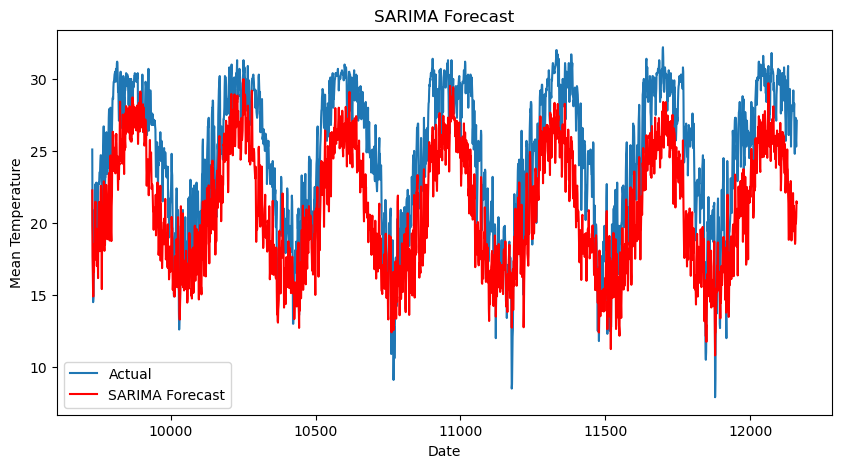

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# Define the SARIMA model parameters
order = (1, 0, 0)  # Non-seasonal order (p, d, q)
seasonal_order = (2, 1, 1, 12)  # Seasonal order (P, D, Q, S)

# Select exogenous variables (all columns except 'Mean Temperature')
exog_train = tem_train[[col for col in tem_train.columns if col != "Mean Temperature"]]
exog_test = tem_test[[col for col in tem_test.columns if col != "Mean Temperature"]]

# Fit the SARIMA model
sarima_model = SARIMAX(endog=tem_train['Mean Temperature'],
                       exog=exog_train,
                       order=order,
                       seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Make predictions
sarima_pred_m = sarima_model_fit.predict(start=tem_test.index[0],
                                        end=tem_test.index[-1],
                                        exog=exog_test)

# Calculate error
mse = mean_squared_error(tem_test['Mean Temperature'], sarima_pred_m)
r2 = r2_score(tem_test['Mean Temperature'], sarima_pred_m)
print('Test MSE:', mse)
print('Test R²: %.3f' % r2)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(tem_test.index, tem_test['Mean Temperature'], label='Actual')
plt.plot(tem_test.index, sarima_pred_m, color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

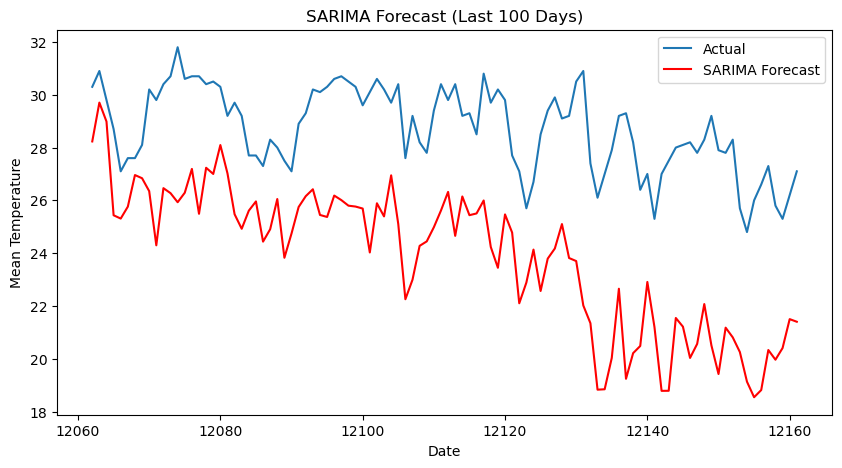

: 

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(tem_test.tail(100).index, tem_test.tail(100)['Mean Temperature'], label='Actual')
plt.plot(tem_test.tail(100).index, sarima_pred_m.tail(100), color='red', label='SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.title('SARIMA Forecast (Last 100 Days)')
plt.legend()
plt.show()
